## Preprocessing
untar cifar-10 dataset:: tar -zxvf backup.tar.gz

In [49]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [2]:
cifar10_PATH = "cifar10/cifar-10-batches-py/"
mnist_PATH = "minst/"

In [57]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
images = []
labels = []
for i in range(1,6):
    d = unpickle(cifar10_PATH+"data_batch_"+str(i))
    labels.append(d[b'labels'])
    data = d[b'data']
    data = data.reshape((-1, 3, 32, 32))
    #.transpose([1, 2, 0])
    images.append(data)
X_train = images[0]
y_train = labels[0]
for i in range(1,5):
    X_train = np.concatenate((X_train, images[i]))
    y_train = np.concatenate((y_train, labels[i]))
print(X_train.shape)
print(y_train.shape)
X_train = X_train / 255.0

(50000, 3, 32, 32)
(50000,)


In [59]:
img1 = X_train[5]
img1 = img1.reshape((3, 32, 32)).transpose([1, 2, 0])
print(img1.shape)
#plt.imshow(img1)

(32, 32, 3)


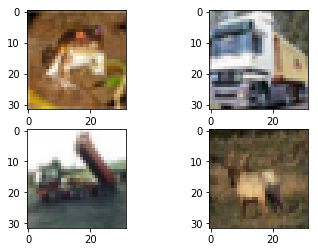

In [58]:
# Some examples
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X_train[0].transpose([1, 2, 0]))
axarr[0,1].imshow(X_train[1].transpose([1, 2, 0]))
axarr[1,0].imshow(X_train[2].transpose([1, 2, 0]))
axarr[1,1].imshow(X_train[3].transpose([1, 2, 0]))

In [42]:
def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    X_train = x_train.astype('float32')
    X_test = x_test.astype('float32')
    return X_train, y_train, X_test, y_test

def labelencoding(y_train, y_val, y_test, nb_classes):
    Y_val = to_categorical(y_val, num_classes = nb_classes)
    Y_test = to_categorical(y_test, num_classes = nb_classes)
    Y_train = to_categorical(y_train.reshape(-1, 1), num_classes = nb_classes)
    return Y_train, Y_val, Y_test

def split_dataset(X_train, Y_train):

    # Set the random seed
    random_seed = 2

    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)
    
    return X_train, X_val, Y_train, Y_val

In [52]:
CLASSES = 10
X_train, Y_train, X_test, Y_test = load_data()
X_train, X_val, Y_train, Y_val = split_dataset(X_train, Y_train)
Y_train, Y_val, Y_test = labelencoding(Y_train, Y_val, Y_test, CLASSES)

In [53]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(40000, 32, 32, 3)
(40000, 10)
(10000, 32, 32, 3)
(10000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [45]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [137]:
model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
sgd = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [57]:
#model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
#model.add(Conv2D(3, (1, 1), activation='linear', input_shape=(32,32,3)))
#model.add(Flatten())
xx = Input(shape=(32,32,3))
x = Flatten()(xx)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)
model = Model(xx,x)

#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(10, activation='softmax'))


#sgd = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                196672    
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                650       
Total para

In [58]:
EPOCHS = 20
BATCH_SIZE = 64
#X_train = X_train.reshape(-1, 3072)
#X_val = X_val.reshape(-1, 3072)
#print(X_train.shape)
#print(Y_train.shape)
#print(X_val.shape)
#print(Y_val.shape)

#def gen(x, y, batch):
    #while True:
   #     for i in range(0, x.shape[0], batch):
            #print(x.shape)
  #          img = x[i:i+batch,:]
            #img.reshape(-1, 3072)
 #           lab = y[i:i+batch,:]
            #print(img.shape)
            #print(lab.shape)
#            yield  img, lab
#            yield ({'input': img}, {'output': lab})

#history = model.fit_generator(gen(X_train, Y_train, BATCH_SIZE),
#                              epochs = EPOCHS,
#                              validation_data = gen(X_val, Y_val, BATCH_SIZE),
#                              steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
#                              validation_steps = X_val.shape[0] // BATCH_SIZE,
#                              callbacks=[learning_rate_reduction])

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

#print(X.shape)
#print(Y_train.shape)
history = model.fit_generator(datagen_train.flow(X_train,Y_train, batch_size=BATCH_SIZE),
                              epochs = EPOCHS,
                              validation_data = datagen_val.flow(X_val, Y_val, batch_size=BATCH_SIZE),
                              steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
                              validation_steps = X_val.shape[0] // BATCH_SIZE,
                              callbacks=[learning_rate_reduction])

Epoch 1/20
625/625 [==============================] - 2s 4ms/step - loss: 2.2597 - acc: 0.1445 - val_loss: 2.1677 - val_acc: 0.2208
Epoch 2/20
625/625 [==============================] - 2s 3ms/step - loss: 2.1699 - acc: 0.1827 - val_loss: 2.0582 - val_acc: 0.2698
Epoch 3/20
625/625 [==============================] - 2s 3ms/step - loss: 2.1161 - acc: 0.2063 - val_loss: 2.0005 - val_acc: 0.2924
Epoch 4/20
625/625 [==============================] - 2s 3ms/step - loss: 2.0797 - acc: 0.2203 - val_loss: 1.9562 - val_acc: 0.3176
Epoch 5/20
625/625 [==============================] - 2s 3ms/step - loss: 2.0490 - acc: 0.2332 - val_loss: 1.9463 - val_acc: 0.3297
Epoch 6/20
625/625 [==============================] - 2s 3ms/step - loss: 2.0295 - acc: 0.2456 - val_loss: 1.9413 - val_acc: 0.3111
Epoch 7/20
625/625 [==============================] - 2s 3ms/step - loss: 2.0128 - acc: 0.2535 - val_loss: 1.8942 - val_acc: 0.3451
Epoch 8/20
625/625 [==============================] - 2s 3ms/step - loss: 1.

{'val_acc': [0.65564903846153844, 0.65044070512820518, 0.70042067307692313, 0.68820112179487181, 0.70713141025641024, 0.71043669871794868, 0.73417467948717952, 0.72786458333333337, 0.72506009615384615, 0.71524439102564108], 'loss': [1.0680349918365479, 0.99551615695953366, 0.94335064201354979, 0.89650293908119205, 0.86312672657966616, 0.84418115301132202, 0.82845677556991582, 0.81864263248443603, 0.81906269507408147, 0.81569369397163394], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 'acc': [0.62697499999999995, 0.65090000000000003, 0.67335, 0.68992500000000001, 0.70215000000000005, 0.71160000000000001, 0.71645000000000003, 0.72045000000000003, 0.72647499999999998, 0.72652499999999998], 'val_loss': [0.97116307455759787, 1.014949647661967, 0.86537031179819357, 0.89309967519381106, 0.87049865416991401, 0.85048737930945861, 0.77474267207659209, 0.80361640682587254, 0.83580351983889556, 0.85475356972370398]}


In [56]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

Y_pred = model.predict(X_test/255.)
Y_pred = np.argmax(Y_pred, axis=1)
y = np.argmax(Y_test, axis=1)
print("Accuracy: {}".format(accuracy_score(y, Y_pred)))
print("F1: {}".format(f1_score(y, Y_pred, average=None)))

Accuracy: 0.3778
F1: [ 0.42595344  0.50657895  0.10487983  0.1379822   0.3666997   0.35553225
  0.4165844   0.38071815  0.44208494  0.46734398]


In [172]:
np.argmax(model.predict(X_test[0:10]/255.), axis=1)

array([3, 8, 1, 0, 6, 6, 9, 6, 3, 9])

In [160]:
y[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [161]:
Y_pred[:10]

array([2, 1, 1, 9, 2, 7, 8, 0, 5, 7])

In [162]:
_ , (_, b) = cifar10.load_data()

In [163]:
b[:10]

array([[3],
       [8],
       [8],
       [0],
       [6],
       [6],
       [1],
       [6],
       [3],
       [1]])